# Interessement and Plan Epargne Entreprise (PEE) analysis

To run the notebook with your data, copy `params_demo.py`, rename it to `params.py` and adjust the values.

If you just want the TLDR go to the [results](#Results).

__TODO: Add more PEE funds and comparisons__

### Disclaimer

- This is not financial advice.

- The software is provided without any warranty as for the LICENSE.

- I am not responsible for any decision based on this software. The software might be incorrect and give not accurate or completely wrong results.

- Past returns are not a guarantee for future returns and they are used here just as a reference

### Rant

Finding the data for the funds has been much more difficult that it should be.
Shame on the banks and companies managing the funds who make it difficult for private investor to access raw data and make truly informed decisions.

In [1]:
import pandas as pd
import numpy as np

# import parameters and constants
import consts
try:
    import params                    
except:
    print("Running in DEMO mode using default values.")
    import params_demo as params

# check parameters for unsupported scenarios
if params.QUOTIENT_FAMILIAL != 1:
    print(
        """"
        Quotient familial is not yet supported in this notebook.
        Feel free to open a PR that adds this feature.
        """
    )

if params.PRIME > consts.PRIME_TAX_EXEMPTION_LIMIT:
    print(
        """
        The prime exceeds the no tax limit.
        This is not yet supported in this notebook.
        Feel free to open a PR that adds this feature.
        """
    )

if params.YEARS < 5:
    print(
        """
        The selected number of years is less than 5.
        The PEE minimum duration is 5 years except in some specific cases like marriage or contract termination.
        """
    )

# create a dictionary to store the results
results = {}

Running in DEMO mode using default values.


## Cash out
Take the cash now instead of PEE

In [2]:
def calculate_impot_revenu_prime(revenus, prime):
    tax = 0.0
    for lower, upper, rate in consts.BAREME_IMPOT_REVENU:
        if revenus > upper:
            continue
        if revenus + prime > lower:
            amount = revenus + prime
            tax += (min(amount, upper) - max(revenus, lower)) * rate
        else:
            break
    return tax

prime_tax = calculate_impot_revenu_prime(params.REVENUS, params.PRIME)
prime_tax_percent = prime_tax / params.PRIME * 100
print(f"Tax rate on the prime is {prime_tax_percent:.2f}%: {prime_tax:.2f} euros")

prime_net = params.PRIME - prime_tax
print(f"Net prime after impôt sur le revenu is {prime_net:.2f} euros")

results["Cash"] = [prime_net]

Tax rate on the prime is 30.00%: 619.80 euros
Net prime after impôt sur le revenu is 1446.20 euros


## Invest

In [3]:
def past_returns(df: pd.DataFrame, initial_amount, gain_tax, entrance_fee = 0) -> pd.DataFrame:
    """
    Run an investment simulation on past data for a `params.YEARS` period.

    df: pd.DataFrame with `date` and `price` columns, monthly frequency
    """

    # make sure data is sorted by date
    sorted = df['price'].sort_index()

    # Apply entrance fee
    initial_amount *= (1 - entrance_fee)
    # Compute the past returns on investment over the configured number of years
    roi = sorted.pct_change(periods=12*params.YEARS)
    gross = initial_amount * (1 + roi)
    # Apply gain tax
    net = gross.apply(lambda x: x if x <= initial_amount else initial_amount + (x - initial_amount) * (1 - gain_tax))
    return net

### PEE CM-AM AVENIR MONETAIRE

In [4]:
# From the KID (Document d’informations clés)
entrance_fee = 0.01

# Load historical data of the fund
df = pd.read_excel("./data/CM-AM AVENIR MONETAIRE.xlsx", skiprows=6, usecols="A:D", parse_dates=["Date de cotation"], date_format='%d/%m/%Y', index_col='Date de cotation', skipfooter=5)


df['price'] = df['Dernier cours en EUR']
results['PEE Monetaire'] = past_returns(df, params.PRIME, consts.PRELEVEMENT_SOCIAUX, entrance_fee)

### PEE CM-AM AVENIR DYNAMIQUE
I wasn't able to find decent data for this fund

### PEE CM-AM PERSPECTIVE CERTITUDE

In [5]:
# From the KID (Document d’informations clés)
entrance_fee = 0.005

df = pd.read_excel("./data/CM-AM PERSPECTIVE CERTITUDE.xlsx", skiprows=6, usecols="A:D", parse_dates=["Date de cotation"], date_format='%d/%m/%Y', index_col='Date de cotation', skipfooter=2)

df['price'] = df['Dernier cours en EUR']
results["PEE Certitude"] = past_returns(df, params.PRIME, consts.PRELEVEMENT_SOCIAUX, entrance_fee)

### PEE SOCIAL ACTIVE TEMPERE SOLIDAIRE

In [6]:
# From the KID (Document d’informations clés)
entrance_fee = 0.005

df = pd.read_excel("./data/SOCIAL ACTIVE TEMPERE SOLIDAIRE.xlsx", skiprows=6, usecols="A:D", parse_dates=["Date de cotation"], date_format='%d/%m/%Y', index_col='Date de cotation', skipfooter=1)

df['price'] = df['Dernier cours en EUR']
results["PEE SA TEMP SOL"] = past_returns(df, params.PRIME, consts.PRELEVEMENT_SOCIAUX, entrance_fee)

### PEE CM-AM AVENIR ACTIONS EUROPE

In [7]:
# From the KID (Document d’informations clés)
entrance_fee = 0.01

df = pd.read_excel("./data/CM-AM AVENIR ACTIONS EUROPE.xlsx", skiprows=6, usecols="A:D", parse_dates=["Date de cotation"], date_format='%d/%m/%Y', index_col='Date de cotation', skipfooter=5)

df['price'] = df['Dernier cours en EUR']
results["PEE Europe"] = past_returns(df, params.PRIME, consts.PRELEVEMENT_SOCIAUX, entrance_fee)

df = df[df.index >= "2009-02"]
results["PEE Europe >2008"] = past_returns(df, params.PRIME, consts.PRELEVEMENT_SOCIAUX, entrance_fee)


### PEA ETF EURO STOXX 50
Cash out and put everything in an ETF, on a plan d'épargne en actions(PEA), having the same benchmark as the PEE Europe fund.

In [8]:
# Fees from bourse direct as an example
entrance_fixed_fee = 5      # for the sake of simplicity
exit_fixed_fee = 6          # transfer out

df = pd.read_csv("./data/AMUNDIEUROSTOXX50UCITSETFDREURC.txt", sep="\t", parse_dates=["date"], dayfirst=True, index_col='date')

df['price'] = df['clot']
results["PEA ETF Europe > 2008"] = past_returns(df, prime_net - entrance_fixed_fee, consts.PRELEVEMENT_SOCIAUX) - exit_fixed_fee

### Livret A / LDDS
What if I cash out and put everything in a livrets défiscalisés.

_Note: these savings accounts have quite low limits that are not taken into account here_

In [9]:
df = pd.read_csv("./data/LIVRET_A.csv", sep=";", skiprows=6,
                 names=["date", "rate"], decimal=",", parse_dates=["date"], index_col='date')
df.sort_index(inplace=True)
# In the past (pre 2000) the rates were quite high, it is more likely that they will be aligned with the recent rates
# (This might be questionable, feel free to change it)
df = df[df.index.year >= 2000]
# Filter to keep only February of any year (at least recently is the only month in which the rate is updated)
df = df[df.index.month == 2]
df['rate'] /= 100
df['returns'] = (df['rate'] + 1).rolling(window=params.YEARS).apply(lambda x: np.prod(x)) - 1
# No gain tax on the Livret A
df['net'] = prime_net * (1 + df['returns'])

results["Livret A"]= df['net']

## Results

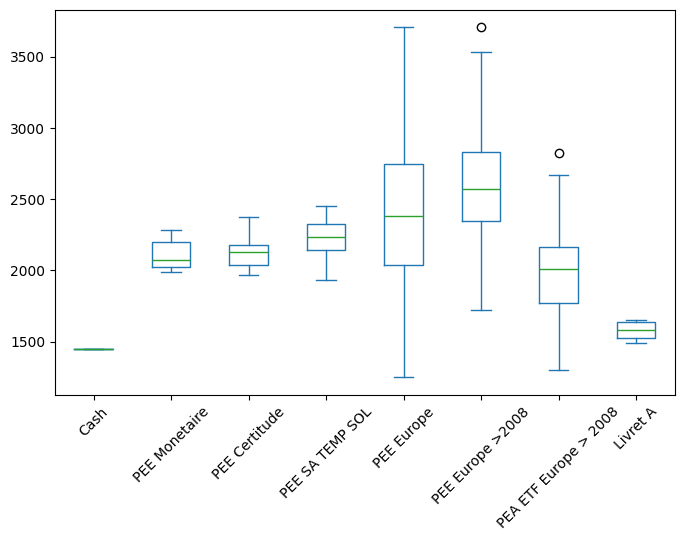

In [10]:
df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in results.items()]))
plt = df.plot(kind='box', figsize=(8,5))
plt.xaxis.set_tick_params(rotation=45)

### Notes

- The graph doesn't show some other important aspects such as the possibility of withdrawal for the different cases.
- Date ranges might not be the same for all products, the maximum data available is generally considered. To have a more fair comparison (but less precise single results) adjust the dates to be the same for each product you are interested in.